## Variant Calling Report v1.2.3
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nexusplt as nxp
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','pipeline_version',
          'h5_concordance_file', 'h5_model_file',
          'model_name_with_gt','model_name_without_gt','model_pkl_with_gt','model_pkl_without_gt'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='var_report.h5')
imgpref = parser.get('VarReport', 'image_output_prefix', fallback=prm['run_id']+'.vars')+'.'
imgdir = 'plots'

sources = {'Trained wo gt':(prm['h5_concordance_file'],"concordance"),
           'Trained with gt':(prm['h5_model_file'],"scored_concordance"),
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    data[s]=d

with pd.HDFStore(prm['h5_concordance_file']) as hdf:
    keys=hdf.keys()
    wg_dfs=[pd.read_hdf(hdf,k) for k in keys if k not in ['/concordance','/input_args']]
    wg_df=pd.concat(wg_dfs)
    
data['whole genome'] = wg_df
sources['whole genome'] = (prm['h5_concordance_file'],"all")
    
prm['mean_var_depth']='{:.2f}'.format(data['Trained wo gt']['well_mapped_coverage'].mean())
prmNames.append('mean_var_depth')
   
try:
    args=pd.read_hdf(sources['Trained wo gt'][0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")

prmdf

,value
run_id,001043-X0024
pipeline_version,2.5.1
h5_concordance_file,/data/classify_gt_short_reprot/001043-X0024.comp.h5
h5_model_file,/data/classify_gt_short_reprot/001043-X0024.model.h5
model_name_with_gt,threshold_model_ignore_gt_incl_hpol_runs
model_name_without_gt,rf_model_ignore_gt_incl_hpol_runs
model_pkl_with_gt,/data/classify_gt_short_reprot/with_gt/001043-X0024.model.pkl
model_pkl_without_gt,/data/classify_gt_short_reprot/no_gt/001043-X0024.model.pkl
mean_var_depth,36.15
truth_sample_name,HG002


In [2]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [3]:
def calcPerformance(data, gt=False):
    classify='classify_gt' 
    d=data.copy()
    
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score','filter']].sort_values(by=['tree_score'])
    
    d['label'] = np.where(d[classify]=='fp',0,1)

    d.loc[d['filter']=='HPOL_RUN','filter']='PASS'
    d.loc[d['filter']=='COHORT_FP','filter']='PASS'
    d.loc[d[classify]=='fn','filter']='MISS'
    d['class'] = np.where(d['label']==0,'FP','FN')
    d.loc[(d['label']==1) & (d['filter']=='PASS'),'class']='TP'
    d.loc[(d['label']==0) & (d['filter']!='PASS'),'class']='TN'

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)

    # The model value
    fn=len(d[d['class']=='FN'])
    tp=len(d[d['class']=='TP'])
    fp=len(d[d['class']=='FP'])

    recall=tp/(tp+fn) if (tp+fn>0) else np.nan
    precision=tp/(tp+fp) if (tp+fp>0) else np.nan
    max_recall=1-len(d[d['filter']=='MISS'])/numPos

    f1=tp/(tp+0.5*fn+0.5*fp)
    
    return (d[['recall','precision']][d['mask']],
            dict({'recall':recall,'precision':precision,'f1':f1}),
            numPos,numNeg)



In [4]:
def plotPerformance(perfCurve,optRes,categories,source=sources,ext=None,img=None):
    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(source):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.get('recall'),opt.get('precision'),'o',color=col[j])
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    if img:
        nxp.save(fig,imgpref+img,'png',outdir=imgdir)
    
    
def getPerformance(data,categories,gt=False):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d,gt)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.get('recall'),
                              'precision':np.nan if perf.empty else opt.get('precision'),
                              'F1':np.nan if perf.empty else opt.get('f1')
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve

## Performance: all Data

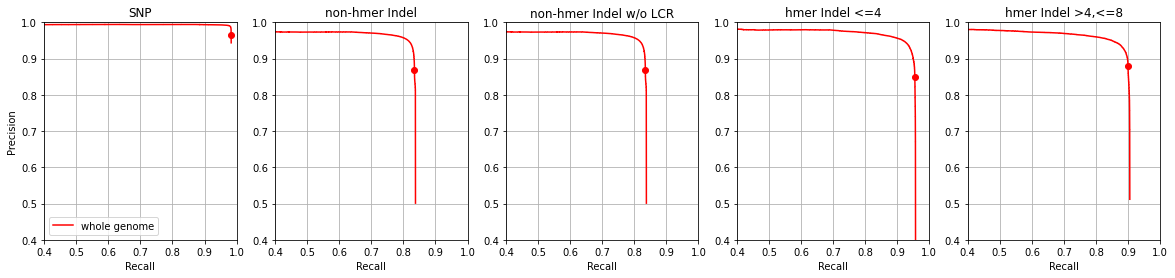

In [5]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']})

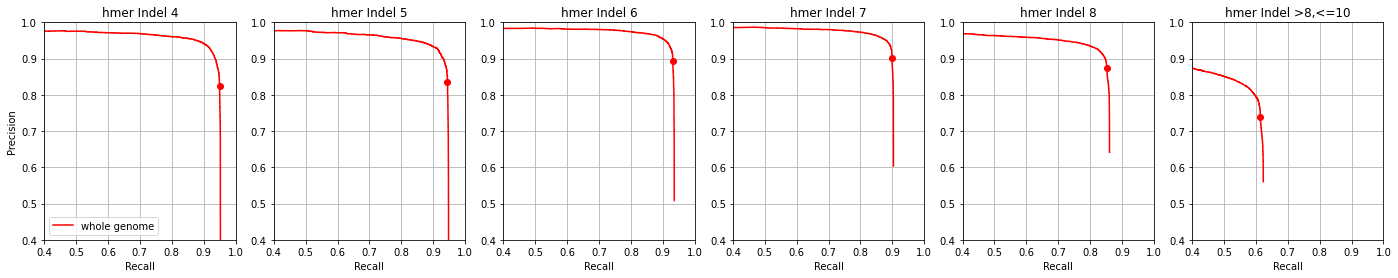

In [6]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'whole genome':sources['whole genome']})

In [7]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data")
df_all=df
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,3358973,197500,98.31%,98.30%,96.58%,97.43%
non-hmer Indel,234044,195227,83.78%,83.38%,86.74%,85.03%
non-hmer Indel w/o LCR,234044,195227,83.78%,83.38%,86.74%,85.03%
hmer Indel <=4,61509,92454,95.71%,95.51%,85.01%,89.96%
"hmer Indel >4,<=8",47943,41396,90.52%,89.97%,87.91%,88.93%
hmer Indel 4,10324,20923,95.26%,94.99%,82.52%,88.32%
hmer Indel 5,8270,16169,94.82%,94.43%,83.64%,88.71%
hmer Indel 6,10806,9780,93.60%,93.16%,89.43%,91.26%
hmer Indel 7,13834,8206,90.34%,89.87%,90.17%,90.02%
hmer Indel 8,15033,7241,86.12%,85.31%,87.33%,86.31%


### Including genotype

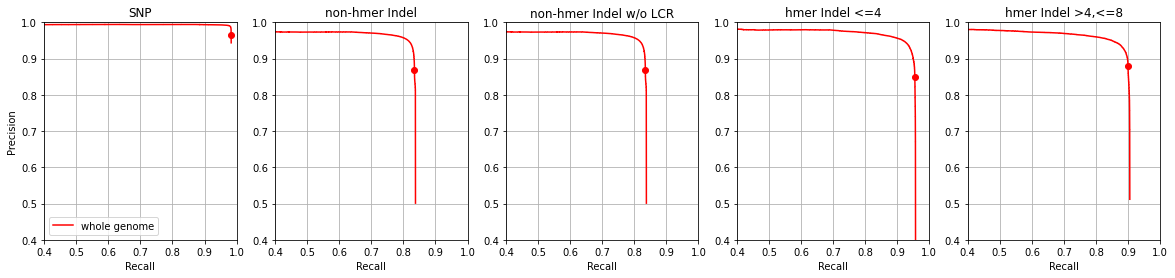

In [9]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(data,categories,gt=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [10]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_gt")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,3358973,197500,98.31%,98.30%,96.58%,97.43%
non-hmer Indel,234044,195227,83.78%,83.38%,86.74%,85.03%
non-hmer Indel w/o LCR,234044,195227,83.78%,83.38%,86.74%,85.03%
hmer Indel <=4,61509,92454,95.71%,95.51%,85.01%,89.96%
"hmer Indel >4,<=8",47943,41396,90.52%,89.97%,87.91%,88.93%


### homozygous genotyping accuracy

In [11]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=data[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_homozygous")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,1282499,73,100.00%,100.00%,99.99%,100.00%
non-hmer Indel,70770,180,100.00%,99.86%,99.76%,99.81%
non-hmer Indel w/o LCR,70770,180,100.00%,99.86%,99.76%,99.81%
hmer Indel <=4,25697,61,100.00%,99.99%,99.77%,99.88%
"hmer Indel >4,<=8",16893,60,100.00%,99.97%,99.68%,99.82%


## Performance: cvg>=20, mappability.0

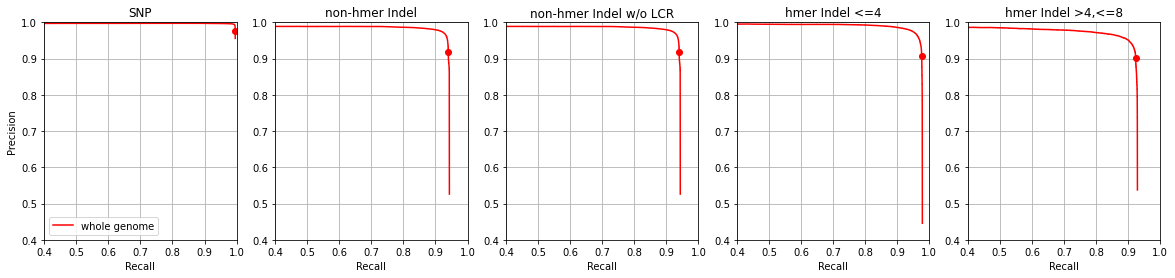

In [12]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})


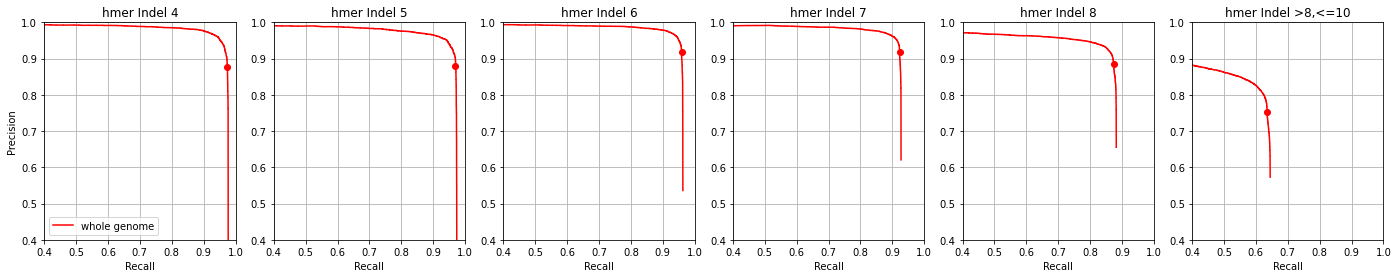

In [13]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})


In [14]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,3168658,146183,99.57%,99.56%,97.64%,98.59%
non-hmer Indel,190407,161775,94.35%,93.92%,91.75%,92.82%
non-hmer Indel w/o LCR,190407,161775,94.35%,93.92%,91.75%,92.82%
hmer Indel <=4,57758,70301,97.83%,97.64%,90.69%,94.04%
"hmer Indel >4,<=8",44691,35712,92.90%,92.34%,90.16%,91.24%
hmer Indel 4,9642,17170,97.71%,97.43%,87.70%,92.31%
hmer Indel 5,7670,13528,97.39%,96.96%,88.08%,92.31%
hmer Indel 6,9968,8307,96.30%,95.89%,91.93%,93.87%
hmer Indel 7,12908,7316,92.73%,92.25%,91.80%,92.03%
hmer Indel 8,14145,6561,88.22%,87.42%,88.58%,88.00%


### Including genotype

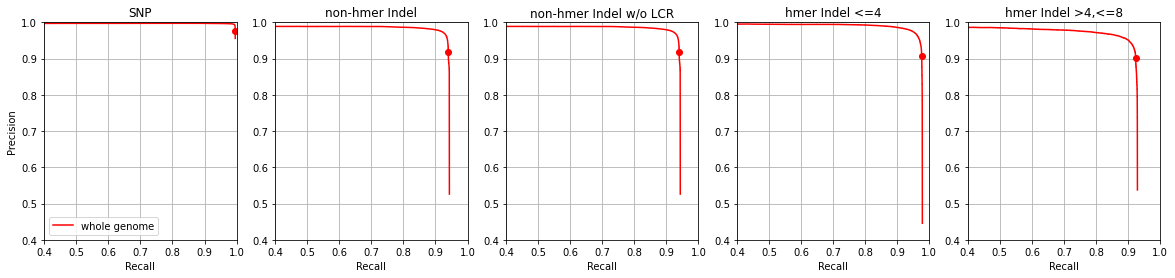

In [15]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [16]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,3168658,146183,99.57%,99.56%,97.64%,98.59%
non-hmer Indel,190407,161775,94.35%,93.92%,91.75%,92.82%
non-hmer Indel w/o LCR,190407,161775,94.35%,93.92%,91.75%,92.82%
hmer Indel <=4,57758,70301,97.83%,97.64%,90.69%,94.04%
"hmer Indel >4,<=8",44691,35712,92.90%,92.34%,90.16%,91.24%


### homozygous calls

In [17]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,1216785,30,100.00%,100.00%,100.00%,100.00%
non-hmer Indel,63753,55,100.00%,99.87%,99.92%,99.89%
non-hmer Indel w/o LCR,63753,55,100.00%,99.87%,99.92%,99.89%
hmer Indel <=4,24474,27,100.00%,100.00%,99.90%,99.95%
"hmer Indel >4,<=8",16048,37,100.00%,99.97%,99.78%,99.88%


### per base

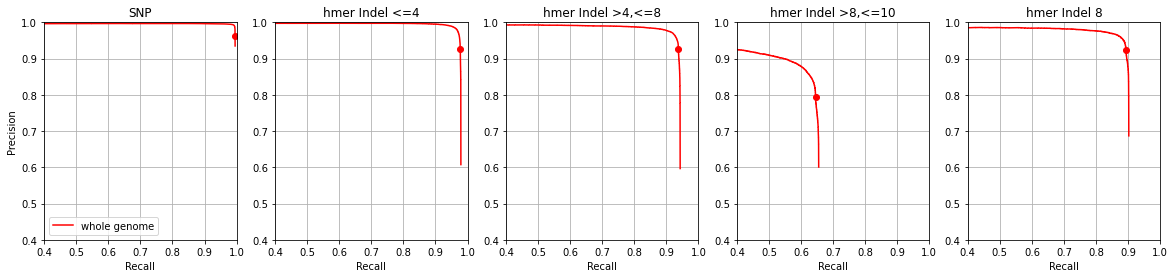

In [18]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

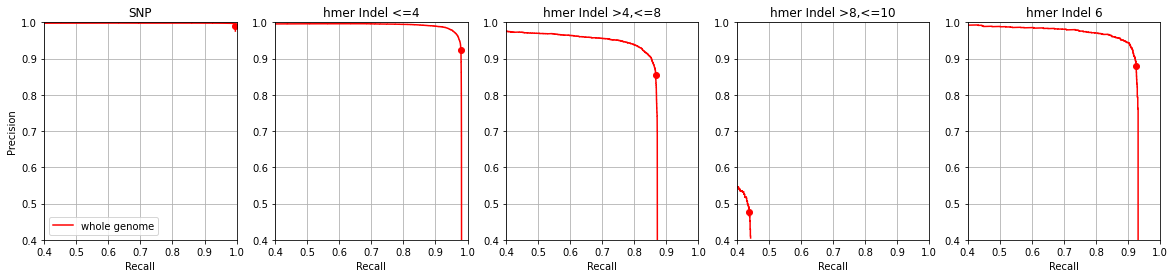

In [19]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [20]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="per_base_data")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP (A/T),1526030,105835,99.53%,99.52%,96.19%,97.83%
hmer Indel <=4 (A/T),35357,22372,97.94%,97.74%,92.77%,95.19%
"hmer Indel >4,<=8 (A/T)",37377,23834,94.31%,93.75%,92.78%,93.27%
"hmer Indel >8,<=10 (A/T)",33723,14681,65.51%,64.58%,79.30%,71.18%
hmer Indel 8 (A/T),12921,5315,90.21%,89.39%,92.32%,90.83%
SNP (C/G),1642628,40348,99.61%,99.59%,99.03%,99.31%
hmer Indel <=4 (C/G),22292,45611,98.14%,97.95%,92.43%,95.11%
"hmer Indel >4,<=8 (C/G)",7186,10866,87.20%,86.65%,85.51%,86.08%
"hmer Indel >8,<=10 (C/G)",1310,853,44.27%,43.82%,47.71%,45.68%
hmer Indel 6 (C/G),1931,3426,93.11%,92.44%,87.89%,90.11%


###  Trained with GT vs without GT

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']})

In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']})

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format
sources={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']}
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="trained_w_wo_gt")
df_all=df
df

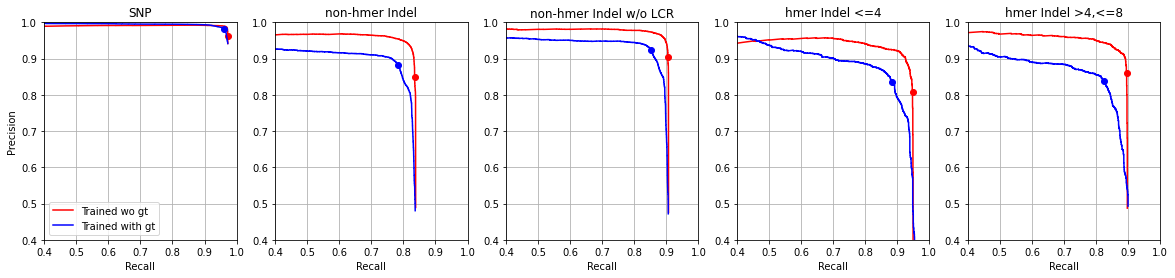

In [6]:
%matplotlib agg
d=defTable['Trained with gt'][['max recall','recall','precision']]
labels=['SNP','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)

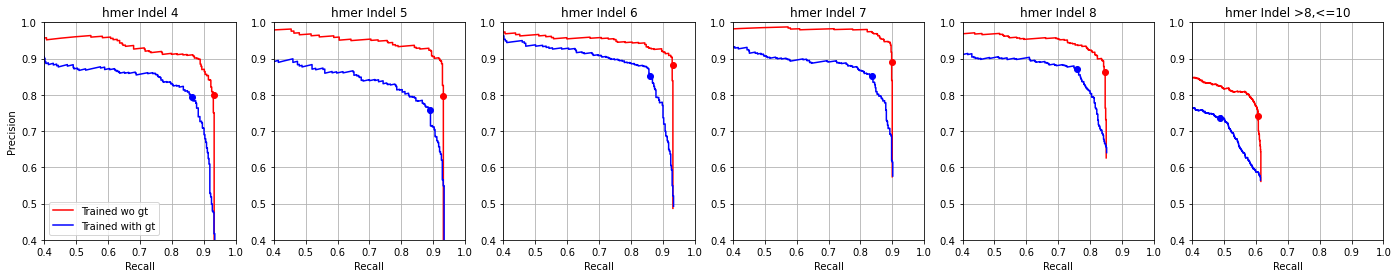

In [10]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']})

In [9]:
pd.options.display.float_format = '{:,.2%}'.format
sources={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']}
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="trained_w_wo_gt")
df_all=df
df

Trained wo gt                                           \
                               # pos # neg max recall recall precision     F1   
SNP                           145897  8787     97.25% 97.22%    96.32% 96.77%   
non-hmer Indel                  9407  8232     83.83% 83.48%    84.87% 84.17%   
non-hmer Indel w/o LCR          6635  6638     90.69% 90.41%    90.52% 90.47%   
hmer Indel <=4                  2332  4159     94.94% 94.81%    80.72% 87.20%   
hmer Indel >4,<=8               1970  1861     89.75% 89.54%    86.13% 87.80%   
hmer Indel 4                     388   917     93.30% 93.30%    79.91% 86.09%   
hmer Indel 5                     352   733     93.18% 93.18%    79.81% 85.98%   
hmer Indel 6                     454   447     93.17% 93.17%    88.12% 90.58%   
hmer Indel 7                     548   367     89.96% 89.78%    88.97% 89.37%   
hmer Indel 8                     616   314     85.06% 84.58%    86.26% 85.41%   
hmer Indel >8,<=10              1504   725     61.57% 60.77%    74.13% 66.79%   

                       Trained with gt                                    \
                                 # pos # neg max recall recall precision   
SNP                             145897  8787     97.25% 96.08%    98.08%   
non-hmer Indel                    9423  8533     83.69% 78.37%    88.20%   
non-hmer Indel w/o LCR            6641  6739     90.60% 85.17%    92.49%   
hmer Indel <=4                    2321  4066     95.39% 88.45%    83.56%   
hmer Indel >4,<=8                 1965  1819     89.97% 82.60%    83.79%   
hmer Indel 4                       385   891     94.03% 86.49%    79.29%   
hmer Indel 5                       350   723     93.71% 88.86%    75.85%   
hmer Indel 6                       453   437     93.38% 85.87%    85.31%   
hmer Indel 7                       547   364     90.13% 83.55%    85.26%   
hmer Indel 8                       615   295     85.20% 75.77%    87.10%   
hmer Indel >8,<=10                1507   715     61.45% 48.84%    73.67%   

                               
                           F1  
SNP                    97.07%  
non-hmer Indel         83.00%  
non-hmer Indel w/o LCR 88.68%  
hmer Indel <=4         85.94%  
hmer Indel >4,<=8      83.19%  
hmer Indel 4           82.73%  
hmer Indel 5           81.84%  
hmer Indel 6           85.59%  
hmer Indel 7           84.40%  
hmer Indel 8           81.04%  
hmer Indel >8,<=10     58.74%

In [20]:
%matplotlib agg
d=defTable['Trained with gt'][['max recall','recall','precision']]
labels=['SNP','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)